logp = 99.964, ||grad|| = 0.39958: 100%|██████████| 16/16 [00:00<00:00, 288.55it/s]  
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


{'l_log__': array(0.8050113349589711), 'sigma_log__': array(-2.921716212071033), 'eps_log__': array(-3.940631081804546), 'l': array(2.236721851826719), 'sigma': array(0.05384120503746343), 'eps': array(0.019435945202878398)}


Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, sigma_log__, l_log__]
INFO:pymc3:NUTS: [eps_log__, sigma_log__, l_log__]
100%|██████████| 1500/1500 [00:57<00:00, 26.19it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.


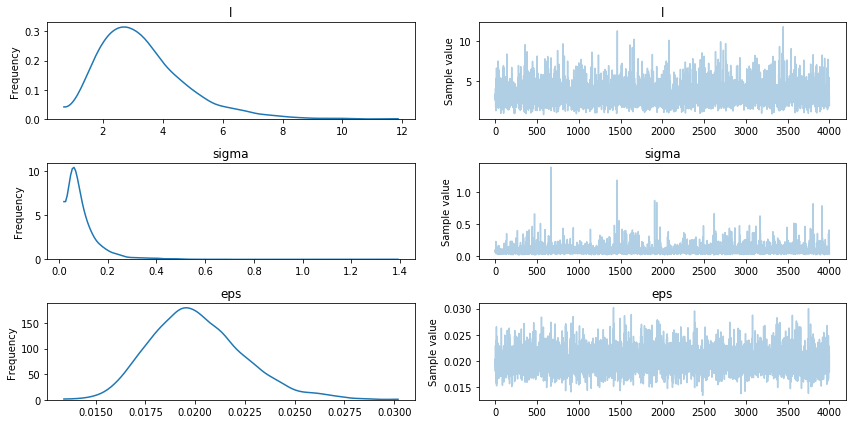

           mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff      Rhat
l      3.311396  1.442623  0.022557  0.942421  6.221507  3095.0  1.000022
sigma  0.100163  0.081196  0.001717  0.022320  0.237621  2443.0  1.001094
eps    0.020135  0.002351  0.000033  0.015883  0.024862  3547.0  0.999716


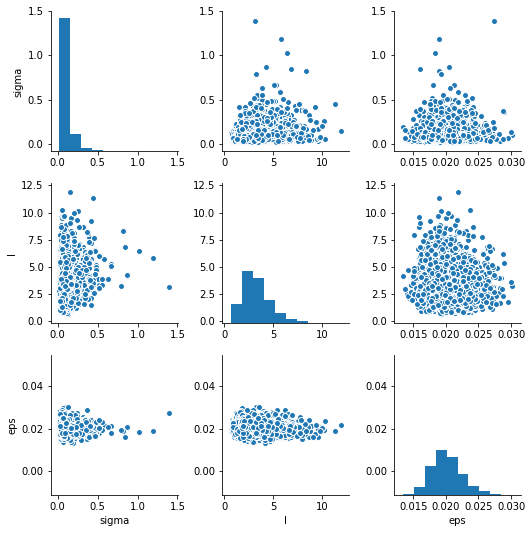

In [7]:
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
from ionotomo import *
from ionotomo.tomography.simulate import SimulateTec
import tensorflow as tf
import numpy as np
import gpflow as gpf
import pymc3 as pm
import os
import pylab as plt
import seaborn as sns

###
# Create radio array



load_preexisting = True
datapack_to_load = "../data/rvw_datapack_full_phase_dec27.hdf5"

if load_preexisting:
    datapack_facets = DataPack(filename=datapack_to_load)
    _,timestamps_flag = datapack_facets.get_times(-1)
    timestamps_flag = timestamps_flag[1:]
    freqs_flag = datapack_facets.get_freqs(-1)
    keep_freqs = freqs_flag[200:220]
    freqs_flag = freqs_flag[np.bitwise_not(np.isin(freqs_flag,keep_freqs))]
    datapack_facets.flag_times(timestamps_flag)
    #datapack_facets.flag_freqs(freqs_flag)
    #Flagged all but first time, channels 200-219, etc
else:
    ra = 126
    dec = 64
    timestamp = "2016-12-08T23:25:01.384"
    radio_array = generate_example_radio_array(config='lofar')
    p0 = ac.SkyCoord(ra=ra*au.deg,dec=dec*au.deg, frame='icrs')
    obstime = at.Time(timestamp,format='isot')
    location = radio_array.get_center()
    altaz = ac.AltAz(location = location, obstime = obstime)
    p = p0.transform_to(altaz)
    print(p)
    datapack_facets = generate_example_datapack(alt=p.alt.deg,az=p.az.deg,Ndir=42,Nfreqs=20,Ntime=1,radio_array=radio_array)

datapack_screen = phase_screen_datapack(15,datapack=datapack_facets)

times, timestamps = datapack_facets.get_times(-1)
antennas,antenna_labels = datapack_facets.get_antennas(-1)
freqs = datapack_facets.get_freqs(-1)

phase_track = datapack_facets.get_center_direction()
obstime = times[0]
location = datapack_facets.radio_array.get_center()

directions_facets,_ = datapack_facets.get_directions(-1)
Nd1 = directions_facets.shape[0]
directions_screen,_ = datapack_screen.get_directions(-1)
Nd2 = directions_screen.shape[0]

uvw = UVW(location = location,obstime=obstime,phase = phase_track)

X0 = directions_facets.transform_to(uvw)
X0 = np.array([np.arctan2(X0.u.value,X0.w.value),np.arctan2(X0.v.value,X0.w.value)]).T

X1 = directions_screen.transform_to(uvw)
X1 = np.array([np.arctan2(X1.u.value,X1.w.value),np.arctan2(X1.v.value,X1.w.value)]).T

x_scale = np.mean(np.std(X1,axis=0))
X1 /= x_scale
X0 /= x_scale


#Simulator
sim = SimulateTec(datapack_screen,spacing=1.,res_n=401)

###
# Generate ionospheres following I(sigma, l)

def sample_ionosphere(sim,sigma,l):
    """Generate an ionosphere, I(sigma,l).
    sim : SimulatedTec object (non reentrant)
    sigma : float log_electron variance
    l : float length scale
    Returns a the model as ndarray
    """
    sim.generate_model(sigma, l)
    model = sim.model
    return model

###
# simulate and place in datapack_screen
def simulate_screen(sim,datapack,s=1.01,ls=10.,draw_new=False):
    if draw_new:
        sim.generate_model(s,ls)
    
    tec = sim.simulate_tec()
    phase = tec[...,None]*-8.4479e9/freqs
    datapack.set_phase(phase,ant_idx=-1,time_idx=[0],dir_idx=-1,freq_idx=-1)
    return tec
            
def log_posterior_true(tec,X1, tec_obs, X0,samples=1000):
    """
    Calculate the logp of the true underlying.
    tec : array (Nd1,)
    X1 : array (Nd1,2)
    tec_obs : array (Nd2,)
    X0 : array (Nd2, 2)
    """
    with pm.Model() as model:
        l = pm.Exponential('l',1.)
        sigma = pm.Exponential('sigma',1.)
        #c = pm.Normal('c',mu=0,sd=1)
        cov_func = pm.math.sqr(sigma)*pm.gp.cov.ExpQuad(1, ls=l)
        #mean_func = pm.gp.mean.Constant(c=c)
        gp = pm.gp.Marginal(cov_func=cov_func)
        eps = pm.HalfNormal('eps',sd=0.1)
        y0_ = gp.marginal_likelihood('y0',X0,tec_obs,eps)
        mp = pm.find_MAP()
        print(mp)
        trace = pm.sample(samples,start={'sigma':0.25,'l':0.25},chains=4)
        pm.traceplot(trace,combined=True)
        plt.show()
    print(pm.summary(trace))
    
    df = pm.trace_to_dataframe(trace, varnames=['sigma','l','eps'])
    sns.pairplot(df)
    plt.show()

    with model:
        y1_ = gp.conditional('y1',X1)#,given={'X':X0,'y':y0,'noise':0.1})
    logp = y1_.logp
        
    logp_val = np.zeros(len(trace))
    for i,point in enumerate(trace):
        point['y1'] = tec
        logp_val[i] = logp(point)
    
    return logp_val


tec = simulate_screen(sim,datapack_screen,draw_new=True)
d_mask = np.random.choice(Nd2,size=Nd1,replace=False)
logp = log_posterior_true(tec[51,0,:],X1,tec[51,0,d_mask],X1[d_mask,:])
# logp = {}
# d_mask = np.random.choice(Nd2,size=Nd1,replace=False)
# for i in range(10):
#     tec = simulate_screen(sim,datapack_screen,draw_new=True)
#     logp[i] = []
#     for ai in range(1,62):
#         print(antenna_labels[ai])
#         tec_mean = np.mean(tec[ai,0,:])
#         tec_std = np.std(tec[ai,0,:])
#         tec_ = (tec[ai,0,:] - tec_mean) / tec_std
#         logp[i].append(np.mean(log_posterior_true(tec_,X1,tec_[d_mask],X1[d_mask,:])))
    

In [6]:

np.max(logp)

-69608.56762156132

-3.141592653589793 3.141592653589793
Plotting 0


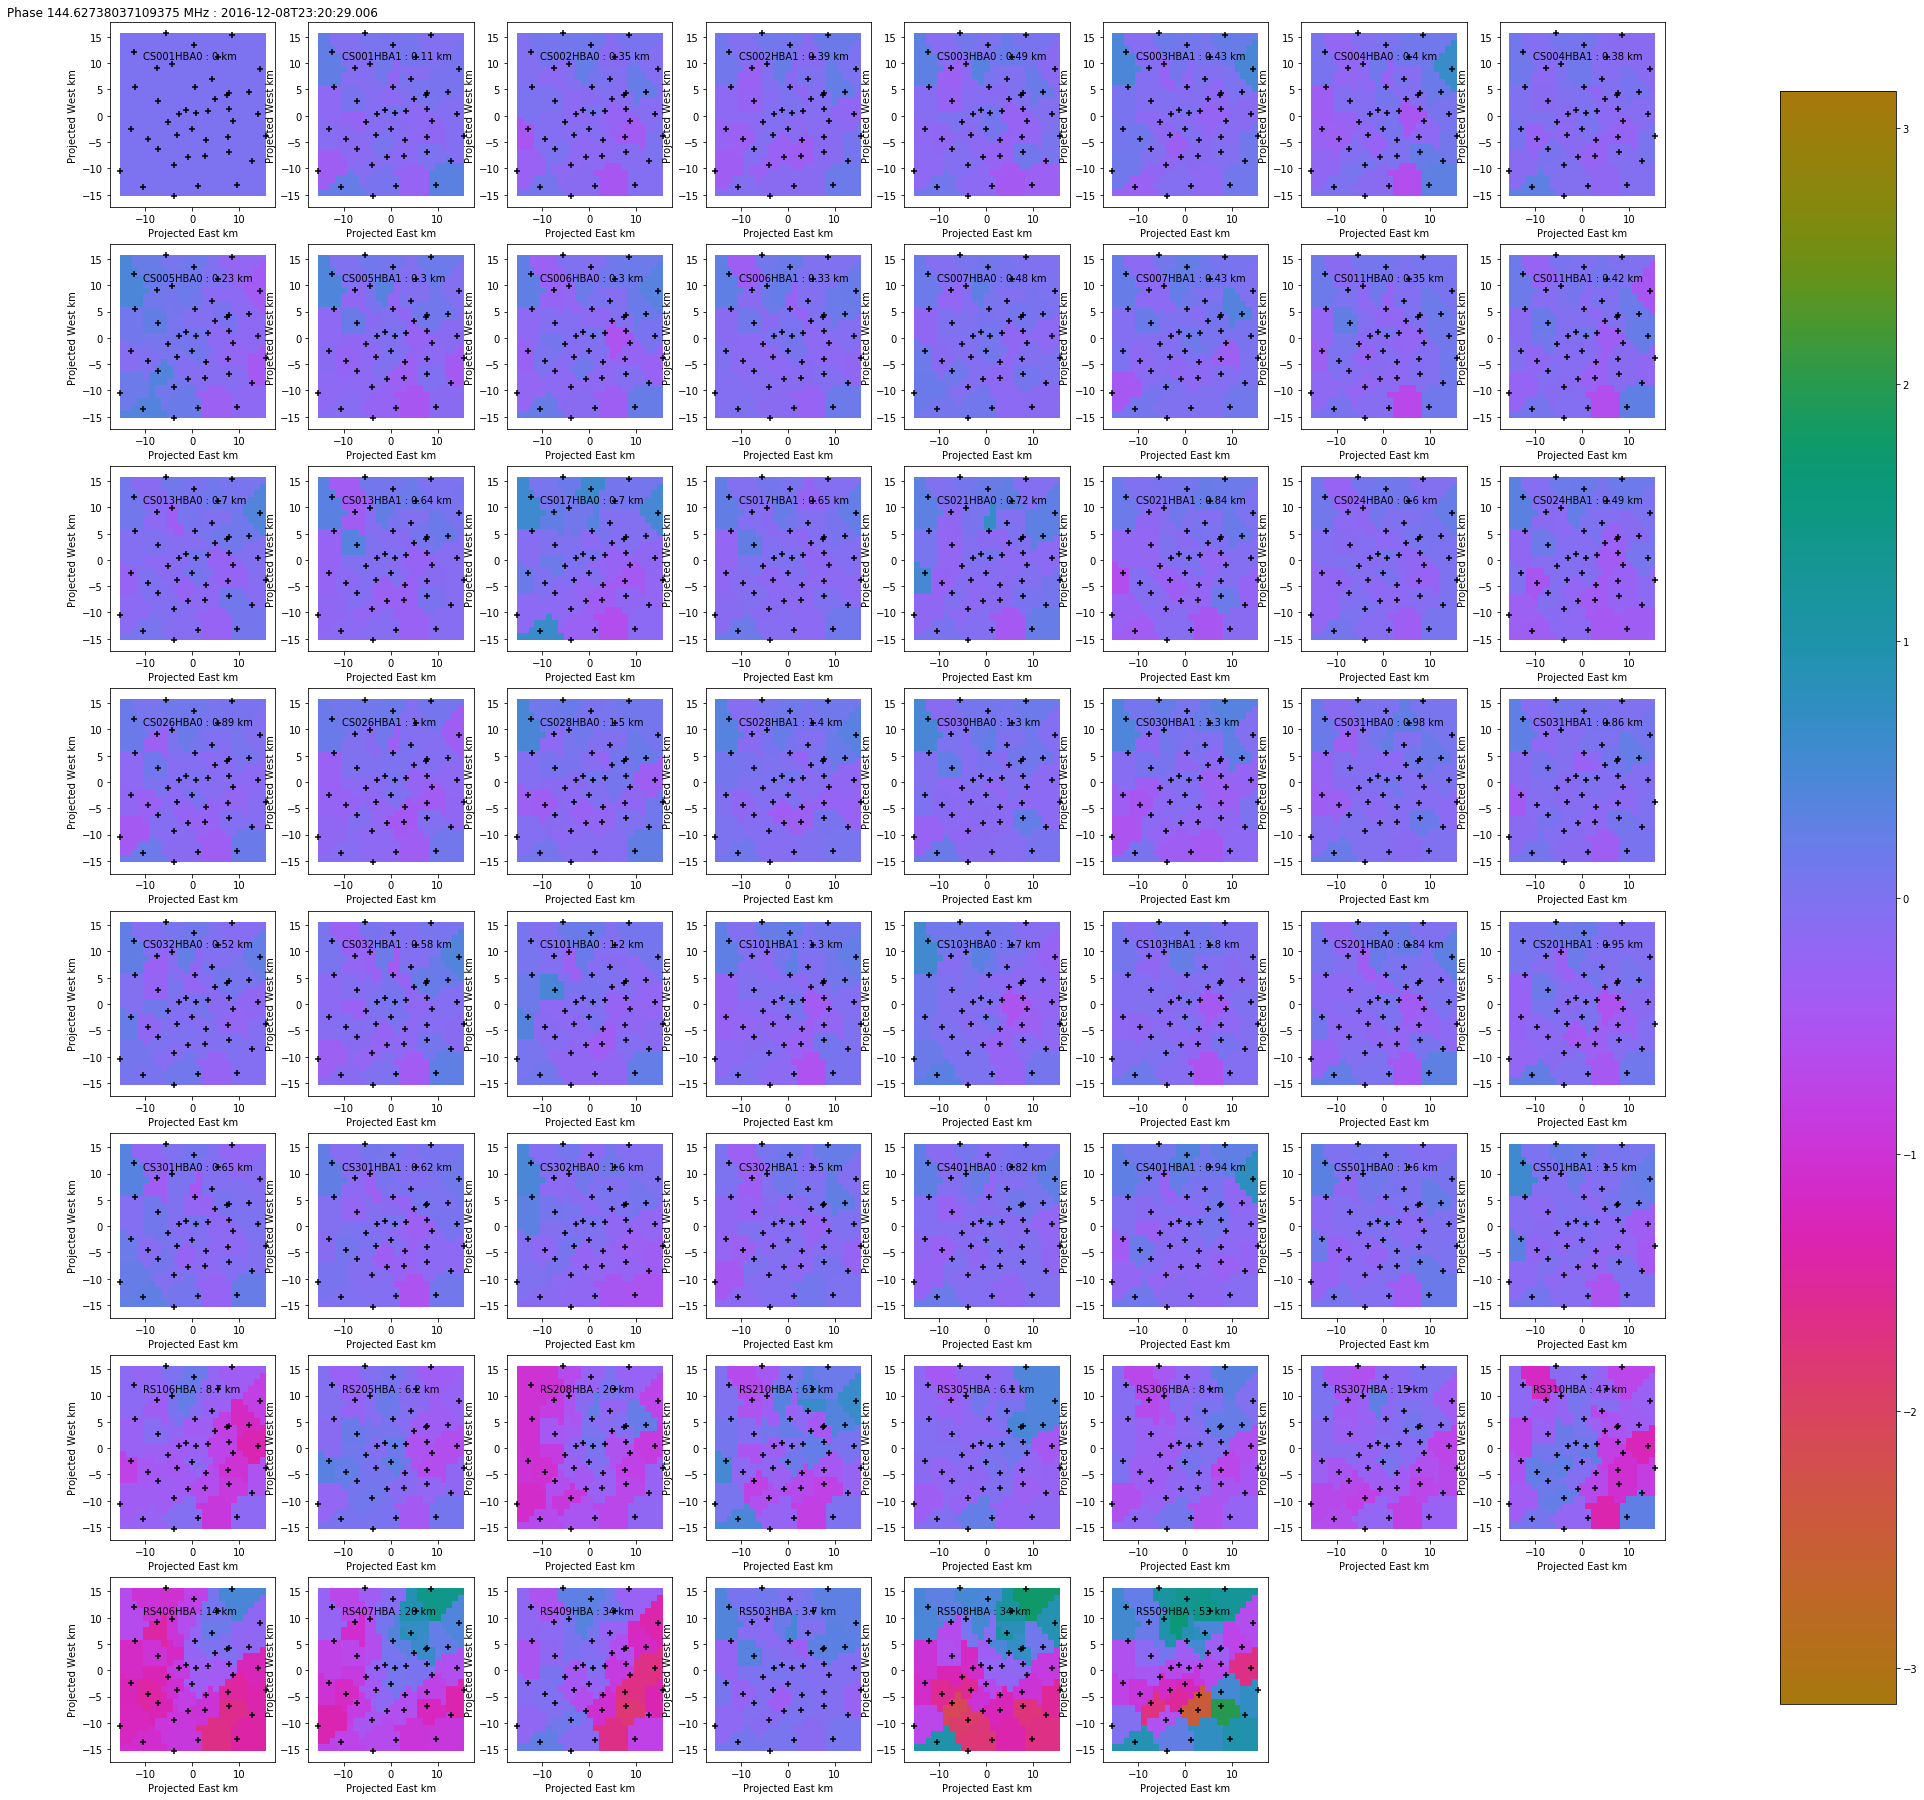

In [5]:
plot_datapack(datapack_facets)

In [2]:


def get_gp_params(model, grid, initial_guess = (None, None), _slice = (slice(0,5*10,5),slice(0,10*10,10),slice(200,400,20))):
    """
    Use gpflow to get GP params MAP.
    Get the sigma, l from model
    model: ndarray, model from sim
    grid: 3-tuple of coord grids
    initial_guess: (sigma_init, l_init)
    _slice : part of model to slice for GP estimation
    returns sigma, l floats
    """
    
    X,Y,Z = np.meshgrid(*grid,indexing='ij')
    X,Y,Z = X[_slice],Y[_slice],Z[_slice]
    x = np.array([X.flatten(),Y.flatten(),Z.flatten()]).T
    x_mean = np.mean(x,axis=0,keepdims=True)
    x -= x_mean
    x_std = np.mean(np.std(x,axis=0,keepdims=True))
    x /= x_std

    f = model[_slice].flatten()

    f_mean = np.mean(f)
    f_std = np.std(f)
    #f -= f_mean
    f /= f_std

    if initial_guess[0] is None:
        initial_sigma = f_std
    else:
        initial_sigma = initial_guess[0]
    if initial_guess[1] is None:
        initial_lengthscale = x_std
    else:
        initial_lengthscale = initial_guess[1]
    # K = gp.SquaredExponential(3,l=0.05,sigma=0.73)
    # K.set_hyperparams_bounds([0.001,2],name='sigma')
    # K.set_hyperparams_bounds([0.05,1],name='l')
    # K.hyperparams = gp.level2_solve(x,f,0.01,K,n_random_start=0)
    # print(K)
    

    o = gp.train.ScipyOptimizer(method='BFGS')

    with gp.defer_build():
        k = gp.kernels.RBF(3,variance=(initial_sigma/f_std)**2,lengthscales=initial_lengthscale/x_std)
        kern = k
        mean = gp.mean_functions.Zero()
    #     l = gp.Gaussian(var=1.0)
        m = gp.models.GPR(x, f[:,None], kern, mean_function=mean)
        m.compile()

        print(o.minimize(m,maxiter=1000))
        print(m)
        return np.sqrt(m.kern.variance.value)*f_std, m.kern.lengthscales.value*x_std

def ne2n(ne,freq=150e6):
    ne_p = 1.2404e-2 * freq**2
    n = np.sqrt(1-ne/ne_p)
    return n

In [7]:
model = sample_ionosphere(sim,1.01,10)
# sigma, l = get_gp_params(np.log(model/sim.model0), sim.grid, initial_guess = (None,None))

In [8]:
model

array([[[  5.74277339e+07,   5.71196262e+07,   5.68853626e+07, ...,
           1.51214787e+10,   1.51269066e+10,   1.50859904e+10],
        [  5.75855812e+07,   5.72738595e+07,   5.70578723e+07, ...,
           1.51567447e+10,   1.51696582e+10,   1.51314670e+10],
        [  5.77771064e+07,   5.74766155e+07,   5.72909271e+07, ...,
           1.52407052e+10,   1.52494506e+10,   1.51937910e+10],
        ..., 
        [  5.89651910e+07,   5.94443075e+07,   5.99212702e+07, ...,
           1.55146104e+10,   1.54368558e+10,   1.53744106e+10],
        [  5.91550591e+07,   5.96188806e+07,   5.99843417e+07, ...,
           1.55209115e+10,   1.54451571e+10,   1.54049613e+10],
        [  5.93273433e+07,   5.97010250e+07,   5.99886353e+07, ...,
           1.55569606e+10,   1.54847669e+10,   1.54458529e+10]],

       [[  5.73883072e+07,   5.71848279e+07,   5.70570325e+07, ...,
           1.51468693e+10,   1.51431397e+10,   1.50881310e+10],
        [  5.76281353e+07,   5.74185270e+07,   5.73117214e+0

In [154]:
print(sigma,l)

0.00141388685618 11.466366344


In [7]:
img = ne2n(model) - ne2n(sim.model0)
img = np.log(model/sim.model0)
plt.imshow(img[:,:,300].T,extent=(sim.grid[0][0],sim.grid[0][-1],sim.grid[1][0],sim.grid[1][-1]))
plt.show()

plt.imshow(img[:,50,:].T,origin='lower',extent=(sim.grid[0][0],sim.grid[0][-1],sim.grid[2][0],sim.grid[2][-1]),aspect='auto')
plt.ylim([200,400])
plt.show()


NameError: name 'plt' is not defined

In [6]:
antenna, antenna_labels = datapack_screen.get_antennas(-1)
print(np.where(antenna_labels=='CS030HBA1'))#1.2
print(np.where(antenna_labels=='RS205HBA'))#6.3
print(np.where(antenna_labels=='RS208HBA'))#26
print(np.where(antenna_labels=='RS509HBA'))#54

(array([29]),)
(array([49]),)
(array([50]),)
(array([61]),)


In [5]:
import pymc3 as pm
import pylab as plt

def get_phase_screen_params(directions,screen,initial_guess = (None, None)):
    directions = directions.transform_to(uvw)
    X = np.array([np.arctan2(directions.u.value,directions.w.value),np.arctan2(directions.v.value,directions.w.value)]).T
    x_mean = np.mean(X,axis=0,keepdims=True)
    X -= x_mean
    x_std = np.mean(np.std(X,axis=0,keepdims=True))
    X /= x_std
    Y = screen[:,None]
    y_mean = np.mean(Y)
    y_std = np.std(Y)
    Y -= y_mean
    Y /= y_std
    
    if initial_guess[0] is None:
        initial_sigma = y_std
    else:
        initial_sigma = initial_guess[0]
    if initial_guess[1] is None:
        initial_lengthscale = x_std
    else:
        initial_lengthscale = initial_guess[1]
        
    with pm.Model() as model:
        l = pm.HalfNormal('l',1.)
        cov_func = pm.gp.cov.ExpQuad(2, ls=l)
        g = pm.gp.Marginal(cov_func=cov_func)
        y = g.marginal_likelihood('y',X,Y,0.1)
        
        
        trace = pm.sample(100,start={'l':initial_lengthscale/x_std})
    pm.traceplot(trace)
    plt.show()
    
#     o = gp.train.ScipyOptimizer(method='BFGS')

#     with gp.defer_build():
#         k = gp.kernels.RBF(2,variance=(initial_sigma/y_std)**2,lengthscales=initial_lengthscale/x_std)
#         kern = k
#         mean = gp.mean_functions.Zero()
#         m = gp.models.GPR(X,Y, kern, mean_function=mean)
#         m.compile()

#         print(o.minimize(m,maxiter=1000))
#         print(m)
#         return np.sqrt(m.kern.variance.value)*y_std, m.kern.lengthscales.value*x_std
    
    
    

100%|██████████| 600/600 [01:22<00:00,  7.23it/s]
ERROR:pymc3:Only 100 samples in chain.
ERROR:pymc3:Only 100 samples in chain.
ERROR:pymc3:Only 100 samples in chain.
ERROR:pymc3:Only 100 samples in chain.


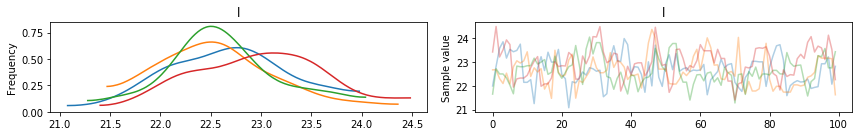

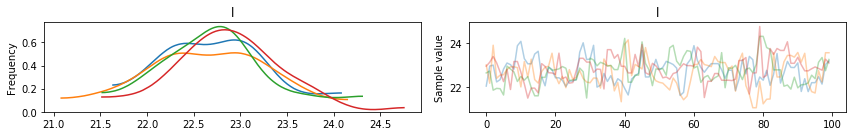

TypeError: 'NoneType' object is not iterable

In [6]:
size = 5
models = []
stats = []
screen_params = {k:[] for k in [29,49,50,61]}

n0 = ne2n(sim.model0,150e6)
for s in [1.001, 1.005, 1.01,1.015, 1.02, 1.025]:
    for ls in [5,10,15,20,25]:
        for i in range(size):
            stats.append((s,ls))
            model = sample_ionosphere(sim,s,ls)
            #n = ne2n(model,freq=150e6) - n0
#             models.append(model)
            tec = sim.simulate_tec()
            phase = tec[...,None]*-8.4479e9/freqs
            
            for i,ai in enumerate([29,49,50,61]):
                sigma,l = get_phase_screen_params(directions, phase[ai,0,:,0])
                print(sigma,l)
                screen_params[ai].append((sigma,l))
                
                
            
            
            #datapack_screen.set_phase(tec[...,None]*-8.4479e9/freqs,ant_idx=-1,time_idx=-1,dir_idx=-1,freq_idx=-1)
            
            #plot_datapack(datapack_screen,vmin=None,vmax=None,phase_wrap=True,plot_crosses=False)
#             sigma, l = get_gp_params(np.log(model/model0), sim.grid, initial_guess = (None,None))
#             print(sigma,l)
#             stats.append((sigma,l))
            
        

In [23]:
stats

[(1.001, 5),
 (1.001, 5),
 (1.001, 5),
 (1.001, 5),
 (1.001, 5),
 (1.001, 10),
 (1.001, 10),
 (1.001, 10),
 (1.001, 10),
 (1.001, 10),
 (1.001, 15),
 (1.001, 15),
 (1.001, 15),
 (1.001, 15),
 (1.001, 15),
 (1.001, 20),
 (1.001, 20),
 (1.001, 20),
 (1.001, 20),
 (1.001, 20),
 (1.001, 25),
 (1.001, 25),
 (1.001, 25),
 (1.001, 25),
 (1.001, 25),
 (1.005, 5),
 (1.005, 5),
 (1.005, 5),
 (1.005, 5),
 (1.005, 5),
 (1.005, 10),
 (1.005, 10),
 (1.005, 10),
 (1.005, 10),
 (1.005, 10),
 (1.005, 15),
 (1.005, 15),
 (1.005, 15),
 (1.005, 15),
 (1.005, 15),
 (1.005, 20),
 (1.005, 20),
 (1.005, 20),
 (1.005, 20),
 (1.005, 20),
 (1.005, 25),
 (1.005, 25),
 (1.005, 25),
 (1.005, 25),
 (1.005, 25),
 (1.01, 5),
 (1.01, 5),
 (1.01, 5),
 (1.01, 5),
 (1.01, 5),
 (1.01, 10),
 (1.01, 10),
 (1.01, 10),
 (1.01, 10),
 (1.01, 10),
 (1.01, 15),
 (1.01, 15),
 (1.01, 15),
 (1.01, 15),
 (1.01, 15),
 (1.01, 20),
 (1.01, 20),
 (1.01, 20),
 (1.01, 20),
 (1.01, 20),
 (1.01, 25),
 (1.01, 25),
 (1.01, 25),
 (1.01, 25),
 (1

In [97]:
import h5py

###
# make arrays
Na = len(list(screen_params.keys()))
sigma_ = []
ls_ = []
sigma_a_ = []
ls_a_ = []
c = 0
for s in [1.001, 1.005, 1.01,1.015, 1.02, 1.025]:
    for ls in [5,10,15,20,25]:
        for i in range(size):
            if c >= 93:
                break
            sigma_.append(s)
            ls_.append(ls)
            sigma_a_.append([screen_params[ai][c][0] for ai in [29,49,50,61]])
            ls_a_.append([screen_params[ai][c][1] for ai in [29,49,50,61]])
            c += 1

sigma_ = np.array(sigma_)[:,None]
ls_ = np.array(ls_)[:,None]
sigma_a_ = np.array(sigma_a_)
ls_a_ = np.array(ls_a_)

with h5py.File("screen_params.hdf5",'w') as f:
    f['sigma'] = sigma_
    f['ls'] = ls_
    f['sigma_a'] = sigma_a_
    f['ls_a'] = ls_a_


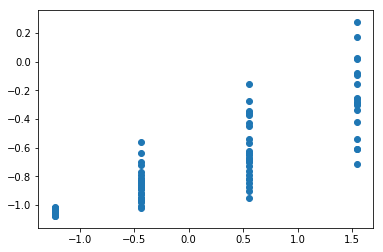

In [95]:
#plt.scatter(ls_,ls_a_[:,0])
#plt.scatter(ls_,ls_a_[:,1])
#plt.scatter(ls_,ls_a_[:,2])
plt.scatter(sigma_,sigma_a_[:,0])
plt.show()

In [85]:
with h5py.File("screen_params.hdf5",'r') as f:
    print(f['ls_a'][...])

[[ 0.0045234   0.00661035  0.00734755  0.00933915]
 [ 0.00502015  0.00794745  0.00608195  0.0080544 ]
 [ 0.0065199   0.00744406  0.00888224  0.00821643]
 [ 0.00616555  0.00724738  0.00755815  0.00857241]
 [ 0.00525561  0.00658975  0.00795766  0.00777964]
 [ 0.00840472  0.00839537  0.01022635  0.01157299]
 [ 0.00675617  0.00886315  0.00980582  0.00867121]
 [ 0.00671153  0.00774023  0.01039808  0.00947552]
 [ 0.00693247  0.00871571  0.01240971  0.00847879]
 [ 0.00876588  0.00972502  0.00909377  0.01141003]
 [ 0.01025928  0.01035451  0.01361036  0.01085292]
 [ 0.00888736  0.01145979  0.01146195  0.01293438]
 [ 0.00793169  0.00916421  0.01101492  0.01033257]
 [ 0.00915012  0.01026774  0.01067963  0.01180335]
 [ 0.00977333  0.01106219  0.01221531  0.0110019 ]
 [ 0.01007263  0.01040486  0.01190641  0.01281002]
 [ 0.00746582  0.00994304  0.01000897  0.0132705 ]
 [ 0.00997702  0.01066252  0.01174276  0.0137885 ]
 [ 0.00940334  0.00914081  0.01073106  0.01216201]
 [ 0.00699449  0.01120108  0.01

In [93]:
sigma_mean = np.mean(sigma_)
sigma_std = np.std(sigma_)
ls_mean = np.mean(ls_)
ls_std = np.std(ls_)

sigma_ = (sigma_ - sigma_mean)/sigma_std
ls_ = (ls_ - ls_mean)/ls_std

sigma_a_ -= np.mean(sigma_a_)
sigma_a_ /= np.std(sigma_a_)
ls_a_ -= np.mean(ls_a_)
ls_a_ /= np.std(ls_a_)

mask = np.random.choice(93,size=93,replace=False)

train = mask[:70]
test = mask[70:]

sigma_train = sigma_[train,:]
ls_train = ls_[train,:]
sigma_a_train = sigma_a_[train,:]
ls_a_train = ls_a_[train,:]

sigma_test = sigma_[test,:]
ls_test = ls_[test,:]
sigma_a_test = sigma_a_[test,:]
ls_a_test = ls_a_[test,:]

100%|██████████| 600/600 [00:13<00:00, 45.39it/s]
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


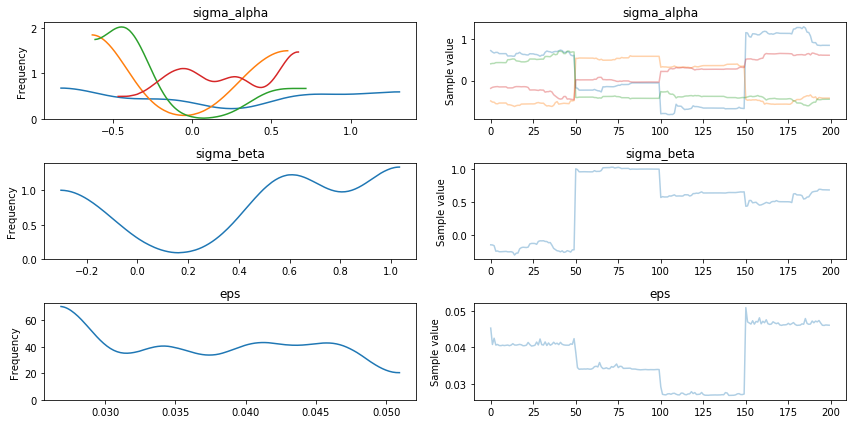

                    mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
sigma_alpha__0  0.235892  0.699326  0.069910 -0.704762  1.294165    2.0   
sigma_alpha__1 -0.034685  0.495942  0.049582 -0.601399  0.591636    2.0   
sigma_alpha__2 -0.176903  0.422459  0.042232 -0.544771  0.707964    2.0   
sigma_alpha__3  0.161393  0.330257  0.033007 -0.386339  0.671288    2.0   
sigma_beta      0.497365  0.437421  0.043728 -0.254997  1.027216    2.0   
eps             0.037276  0.007289  0.000728  0.026836  0.046925    2.0   

                     Rhat  
sigma_alpha__0   9.478441  
sigma_alpha__1  13.042928  
sigma_alpha__2   7.825127  
sigma_alpha__3   5.850528  
sigma_beta       9.437558  
eps             16.832417  


In [102]:
with pm.Model() as model:
    sigma_alpha = pm.Normal('sigma_alpha',mu = 0, sd = 1, shape=sigma_a_.shape[1])
    sigma_beta = pm.Normal('sigma_beta',mu=0,sd=1)
    sigma = pm.math.sum(sigma_alpha[None,:]*sigma_a_) + sigma_beta
    eps = pm.HalfNormal('eps',1)
    y = pm.Normal('sigma',mu=sigma,sd=eps,observed = sigma_)
    trace = pm.sample(500, tune=100,live_plot=True, skip_first=200, refresh_every=500, roll_over=1000,nuts_kwargs={'target_accept':0.8})
    pm.traceplot(trace[::10],combined=True)
    plt.show()
    print(pm.summary(trace))
    

In [94]:
###
# p(sigma,l | sigma_a, l_a) = p(sigma_a, l_a | sigma, l) p(sigma, l)

import pylab as plt
import tensorflow as tf

graph = tf.Graph()
L = 100

with graph.as_default():
    true_sigma = tf.placeholder(shape=(None,1),dtype=tf.float32,name='sigma_true')
    true_ls = tf.placeholder(shape=(None,1),dtype=tf.float32,name='ls_true')
    sigma_a = tf.placeholder(shape=(None,Na),dtype=tf.float32,name='sigma_a')
    ls_a = tf.placeholder(shape=(None,Na), dtype=tf.float32, name='ls_a')
    keep_prob = tf.placeholder(shape=(),dtype=tf.float32,name='keep_prob')
    combine = tf.concat([sigma_a,ls_a],axis=1)
    dense = tf.layers.dense(combine,Na,activation=tf.nn.tanh)
    dense = tf.layers.dense(dense,Na,activation=tf.nn.tanh)
    dense = tf.layers.dropout(dense,rate = 1-keep_prob)
    sigma_mu = tf.layers.dense(dense,1,activation=None)
    sigma_sd = tf.layers.dense(dense,1,activation=tf.nn.relu)
    ls_mu = tf.layers.dense(dense,1,activation=None)
    ls_sd = tf.layers.dense(dense,1,activation=tf.nn.relu)
    
    sample_shape = tf.concat([tf.shape(sigma_a),tf.constant([L],dtype=tf.int32)],axis=0)
    sigma_samples = sigma_mu[...,None] + sigma_sd[...,None]*tf.random_normal(shape=sample_shape,dtype=tf.float32, name='sigma_samples')
    ls_samples = ls_mu[...,None] + ls_sd[...,None]*tf.random_normal(shape=sample_shape,dtype=tf.float32, name='ls_samples')
    
    loss = tf.reduce_mean(tf.square(ls_samples - true_ls[...,None]))+tf.reduce_mean(tf.square(sigma_samples - true_sigma[...,None]))
    opt = tf.train.AdamOptimizer(1e-3)
    
    train_op = opt.minimize(loss)

    
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 0
    p = 0
    last_test = np.inf
    while epoch < 10000:
        _,loss_val = sess.run([train_op, loss], feed_dict = {true_sigma:sigma_train,
                                                            true_ls:ls_train,
                                                            sigma_a:sigma_a_train,
                                                            ls_a:ls_a_train,
                                                            keep_prob:0.6})
        if (epoch + 1) % 100 == 0:
            _,test_loss_val = sess.run([train_op, loss], feed_dict = {true_sigma:sigma_test,
                                                            true_ls:ls_test,
                                                            sigma_a:sigma_a_test,
                                                            ls_a:ls_a_test,
                                                            keep_prob:1.})
            print("epoch {} : loss {}, test loss {}".format(epoch,loss_val, test_loss_val))
            if test_loss_val > last_test:
                p += 1
            else:
                last_test = test_loss_val
                p = 0
            if p > 3:
                break
            
        epoch += 1
    
    sigma_mu_val,ls_mu_val = sess.run([sigma_mu,ls_mu], feed_dict = {
                                                        sigma_a:sigma_a_test,
                                                        ls_a:ls_a_test,
                                                        keep_prob:1.})
    print(sigma_mu_val*sigma_std + sigma_mean, ls_mu_val*ls_std + ls_mean)
    print(sigma_test*sigma_std + sigma_mean,ls_test*ls_std + ls_mean)

        
        
    
    
    
    
    

# with pm.Model() as model:
    
#     sigma = pm.Uniform('sigma', lower=0,upper=1)
    
#     l = pm.Uniform('l',lower=0,upper=1)
    
    
    
#     Sconst = pm.Uniform('C',lower=0, upper=100)
    
#     h = pm.Deterministic('h',S100*(0.100)**alpha + Sconst)
    
#     S = S100*(freqs)**alpha + Sconst
#     sigma = 0.05#pm.Uniform('sigma',lower=0,upper=1.)
#     var_log = pm.math.log(1 + noise**2/S**2)
#     mu_log = pm.math.log(S) - 0.5*var_log
    
#     y = pm.Normal('yalpha = pm.Uniform('B', lower=0,upper=1)
    
#     S100 = pm.Uniform('A',lower=0,upper=1000)
    
#     Sconst = pm.Uniform('C',lower=0, upper=100)
    
#     h = pm.Deterministic('h',S100*(0.100)**alpha + Sconst)
    
#     S = S100*(freqs)**alpha + Sconst
#     sigma = 0.05#pm.Uniform('sigma',lower=0,upper=1.)
#     var_log = pm.math.log(1 + noise**2/S**2)
#     mu_log = pm.math.log(S) - 0.5*var_log
    
#     y = pm.Normal('y',mu=S,sd=noise,observed=S_obs)
    
#     trace = pm.sample(1000, tune=1000,live_plot=True, skip_first=100, refresh_every=500, roll_over=1000,nuts_kwargs={'target_accept':0.8})
#     pm.traceplot(trace[::10],combined=True)
#     plt.show()
#     print(pm.summary(trace))',mu=S,sd=noise,observed=S_obs)
    
#     trace = pm.sample(1000, tune=1000,live_plot=True, skip_first=100, refresh_every=500, roll_over=1000,nuts_kwargs={'target_accept':0.8})
#     pm.traceplot(trace[::10],combined=True)
#     plt.show()
#     print(pm.summary(trace))

epoch 99 : loss 1.1705584526062012, test loss 1.3005242347717285
epoch 199 : loss 0.6683794260025024, test loss 0.8646541833877563
epoch 299 : loss 0.4441211223602295, test loss 0.5713265538215637
epoch 399 : loss 0.3165878653526306, test loss 0.38584935665130615
epoch 499 : loss 0.2583022117614746, test loss 0.2954770028591156
epoch 599 : loss 0.23028519749641418, test loss 0.2597624659538269
epoch 699 : loss 0.21376588940620422, test loss 0.24502485990524292
epoch 799 : loss 0.20161783695220947, test loss 0.23670029640197754
epoch 899 : loss 0.19206440448760986, test loss 0.23095902800559998
epoch 999 : loss 0.18436981737613678, test loss 0.22757995128631592
epoch 1099 : loss 0.17793361842632294, test loss 0.22577092051506042
epoch 1199 : loss 0.17232337594032288, test loss 0.22461983561515808
epoch 1299 : loss 0.16726690530776978, test loss 0.22357989847660065
epoch 1399 : loss 0.1626358926296234, test loss 0.2224864512681961
epoch 1499 : loss 0.15839393436908722, test loss 0.221409

In [66]:
ls_

array([[-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 1.54564908],
       [ 1.54564908],
       [ 1.54564908],
       [ 1.54564908],
       [ 1.54564908],
       [-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-1.35829768],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [-0.63231099],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.0936757 ],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 0.81966239],
       [ 1

In [112]:
stats[:,0]


array([  5.68806787e-10,   5.73408353e-10,   3.86672771e-08,
         5.61783782e-10,   5.51511413e-08,   4.72320901e-08,
         7.40411248e-08,   1.04865927e-07,   8.06497771e-08,
         8.59548328e-08,   3.74962402e-08,   1.18310000e-07,
         1.75434649e-07,   1.04448173e-07,   8.36098263e-08,
         1.87584206e-07,   1.85336405e-07,   1.17546137e-07,
         9.13587065e-08,   2.76576808e-08,   2.29316821e-07,
         2.60484757e-07,   1.81764521e-07,   2.42341778e-07,
         6.54252448e-10,   2.83061769e-09,   2.88719326e-09,
         3.02338693e-07,   2.85500760e-07,   2.87481264e-09,
         2.72333955e-09,   5.63823610e-07,   3.06461718e-09,
         3.00335867e-07,   6.30340589e-07,   6.40349287e-07,
         3.10224255e-07,   4.95465226e-07,   5.21455113e-07,
         4.25184647e-07,   1.30945817e-06,   4.81632282e-07,
         3.07712678e-07])